In [1]:
%load_ext cython

In [22]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics as st

In [33]:
def timeit(func, *args, return_time=False, **kwargs):
    start = time.time()
    ret = func(*args, **kwargs)
    end = time.time()
    if not return_time:
        print( (end-start))
        return ret
    return end-start, ret
時間=timeit

In [4]:
def mandelbrot_nocython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break


In [5]:
%%cython -a
import numpy as np

def mandelbrot_cython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [11]:
%%cython -a
import numpy as np

def mandelbrot_cython_types(int[:,::1] m,
                      int size,
                      int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [20]:
size = 30
s = (size, size)
m = np.zeros(s, dtype=np.int32)
elapsed_c = []
elapsed_p = []
elapsed_ct = []
load = 50000
tests = 30
for i in tqdm(range(tests)):
    elapsed_c.append(時間(mandelbrot_cython,m, size, load, return_time=True)[0])
    elapsed_p.append( 時間(mandelbrot_nocython,m, size, load, return_time=True)[0])
    elapsed_ct.append( 時間(mandelbrot_cython_types,m, size, load, return_time=True)[0])

100%|██████████| 30/30 [06:39<00:00, 13.33s/it]


In [41]:
a_ec = sum(elapsed_c)/len(elapsed_c)
a_ep = sum(elapsed_p)/len(elapsed_p)
a_ect = sum(elapsed_ct)/len(elapsed_ct)

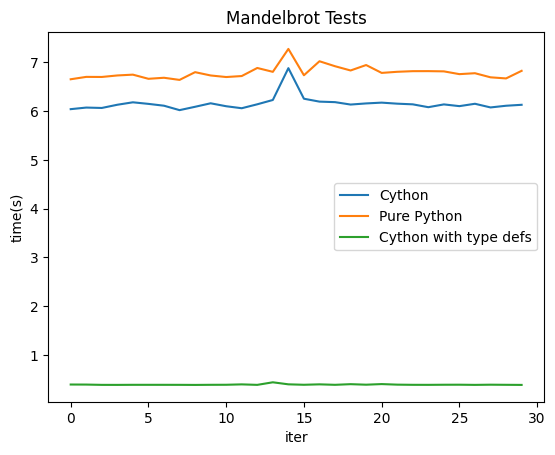

In [26]:
plt.plot(elapsed_c, label='Cython')
plt.plot(elapsed_p, label='Pure Python')
plt.plot(elapsed_ct, label='Cython with type defs')
plt.xlabel("iter")
plt.ylabel("time(s)")
plt.legend()
plt.title("Mandelbrot Tests")
plt.show()

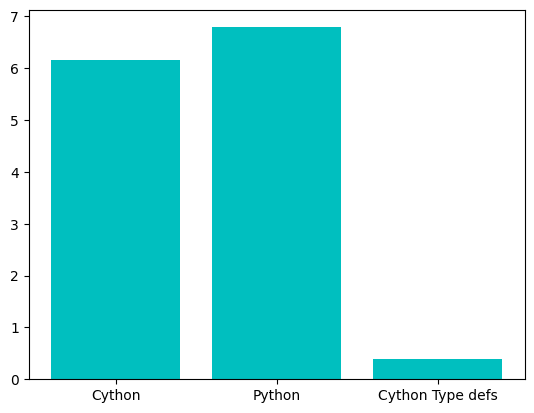

In [43]:
plt.bar(["Cython","Python","Cython Type defs"],[a_ec, a_ep, a_ect], color="c")
plt.show()

In [28]:
from math import sqrt

class  Planet(object):
  def __init__(self):  
    self.x = 1.0
    self.y = 0.0
    self.z = 0.0
    self.vx=0.0
    self.vy= 0.5
    self.vz = 0.0
    self.m =1.0

def single_step(planet,dt):

    distance =sqrt(planet.x**2 + planet.y**2 + planet.x**2)    
    Fx = -planet.x/distance**3
    Fy = -planet.y/distance**3
    Fz = -planet.z/distance**3


    planet.x +=dt*planet.vx
    planet.y += dt*planet.vy
    planet.z += dt*planet.vz

    planet.vx += dt * Fx/planet.m
    planet.vy += dt * Fy/planet.m
    planet.vz += dt * Fz/planet.m

def step_time(planet,time_span,n_steps):   
    dt = time_span / n_steps

    for j in range(n_steps):
        single_step(planet,dt)

def main(iters = 1000000):   
    miPlanet = Planet()
    step_time(miPlanet,5000,iters)


In [29]:
%%cython -a

cdef extern from "math.h":
 double sqrt(double x)

cdef class  Planet_c(object):
  cdef public double x,y,z,vx,vy,vz,m
  def __init__(self):  
    self.x = 1.0
    self.y = 0.0
    self.z = 0.0
    self.vx=0.0
    self.vy= 0.5
    self.vz = 0.0
    self.m =1.0

cdef void single_step(Planet_c planet, double dt):
    cdef double distance,Fx,Fy,Fz
    distance =sqrt(planet.x**2 + planet.y**2 + planet.x**2)    
    
    Fx = -planet.x/distance**3
    Fy = -planet.y/distance**3
    Fz = -planet.z/distance**3

    planet.x +=dt*planet.vx
    planet.y += dt*planet.vy
    planet.z += dt*planet.vz

    planet.vx += dt * Fx/planet.m
    planet.vy += dt * Fy/planet.m
    planet.vz += dt * Fz/planet.m

cdef  void step_time_c(Planet_c planet, double time_span, int n_steps):   

    dt = time_span / n_steps
    cdef int j
    for j in range(n_steps):
        single_step(planet,dt)

def main_c(iters = 1000000):   
 miPlanet = Planet_c()
 step_time_c(miPlanet,5000,iters)


In [34]:
sp = []
sc = []
load = 100000
tests = 30
for i in tqdm(range(tests)):
    sp.append(時間(main, iters=load, return_time = True)[0])
    sc.append(時間(main_c, iters=load, return_time = True)[0])
asp = sum(sp)/len(sp)
asc = sum(sc)/len(sc)
print(f"Python: {asp} Cython: {sum(sc)/len(sc)} Ratio: {asp/asc}")

100%|██████████| 30/30 [00:05<00:00,  5.51it/s]

Python: 0.17060466607411703 Cython: 0.01013806660970052 Ratio: 16.828126371834593


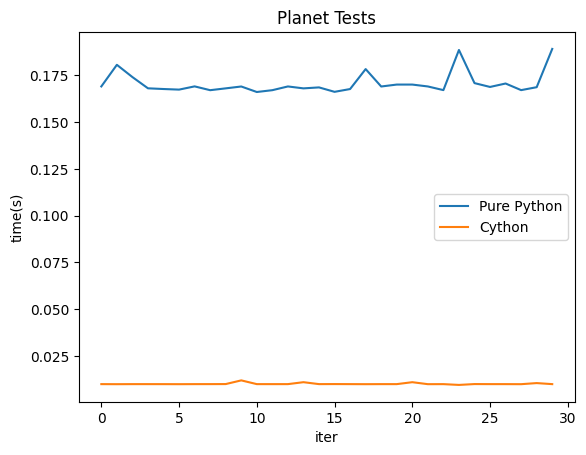

In [35]:
plt.plot(sp, label='Pure Python')
plt.plot(sc, label='Cython')
plt.xlabel("iter")
plt.ylabel("time(s)")
plt.legend()
plt.title("Planet Tests")
plt.show()

<BarContainer object of 2 artists>

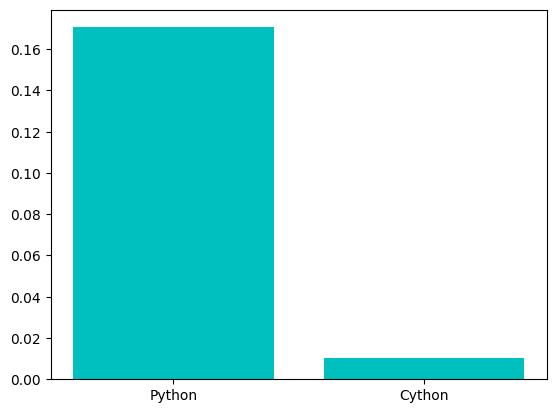

In [40]:
plt.bar(["Python","Cython"],[asp,asc], color="c")

https://ipython-books.github.io/55-accelerating-python-code-with-cython/